# Whisper Model (Large & Small) Evaluation On Audio Length

1. Compute Audio Length for Each Transcription
2. Compute Error
3. Generate Plots
***
### Error Metrics
1. WER
2. ROUGE

***

## Using Custom Kernel on SCC

SCC sometimes has the problem with installed library not importable [`module not found` error], this is an alternative.

Assuming you have a conda environment created, you would do the following:
1. `conda install -c anaconda ipykernel` 
2. `python -m ipykernel install --user --name=<env name>`
3. If the new kernel cannot be found, relaunch a new SCC instance

**Remember to switch to the conda env kernel**

In [5]:
ds_transcript_path = "/projectnb/ds549/projects/AImpower/datasets/updated_annotation_deid_full"

In [2]:
!pip install pandas numpy scipy tqdm

***

# Imports & Ingestion of Data (Whisper Large) [skip if analyzed csv data exists]
**We will be using the data generated from `whisper-stu-eval.ipynb`.**

In [1]:
import pandas as pd
import numpy as np
import scipy 
import os
import sys
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
net_data = pd.DataFrame(columns=["Filename", "Start_time", "End_time", "Transcript"]) 

cols = list(pd.read_csv("net_aigenerated_data_whisper_large_performance_stu.csv", nrows=1))
print(cols)

net_aigenerated_data_whisper_large = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-whisper/net_aigenerated_data_whisper_large_performance_stu.csv', delimiter=',', usecols =[i for i in cols if "Unnamed:" not in i])

['Unnamed: 0', 'Filename', 'Start_time', 'End_time', 'Whisper_large', 'WER', 'Stuttering_Count', 'Stu-wer-compared-groundtruth', 'NA_Count', 'NA_Cleaned_Count', 'WER_Binned', 'stu-rouge1-precision', 'stu-rouge1-recall', 'stu-rouge1-f1', 'stu-rouge2-precision', 'stu-rouge2-recall', 'stu-rouge2-f1', 'stu-rougel-precision', 'stu-rougel-recall', 'stu-rougel-f1', 'Stu-rouge-compared-groundtruth', 'Duration', 'Freq_Duration', 'Freq_CharCount']


In [6]:
for folder in os.listdir(ds_transcript_path):
    if folder == "command_stats.xlsx" or folder == "command_stats.csv":
        continue
    for audio_sample in os.listdir(os.path.join(ds_transcript_path, f"{folder}")):
        if ("_A.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_A")])
        if ("_B.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_B")])
        if ("P" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"P{folder}")])

In [7]:
mask_pattern = r"\<.*?\>"
repetition_pattern = r"\[.*?\]"
annotation_pattern = r"/\w"


net_data = net_data.assign(Cleaned_Transcript=net_data['Transcript'].apply(lambda x: re.sub(annotation_pattern, "", re.sub(repetition_pattern, "", re.sub(mask_pattern, "", x)))))
net_data = net_data.assign(Stutterance_Count=net_data['Transcript'].apply(lambda x: len(re.findall(mask_pattern, x)) + len(re.findall(repetition_pattern, x)) + len(re.findall(annotation_pattern, x))))

In [8]:
net_data

,Filename,Start_time,End_time,Transcript,Cleaned_Transcript,Stutterance_Count
0,D0045_A,48.330,58.020,嗯，我[我/b我]现在已经工作了，我是/p一八年毕业的，然后我的专业是/p国际经济与贸易。,嗯，我现在已经工作了，我是一八年毕业的，然后我的专业是国际经济与贸易。,4
1,D0045_A,58.900,72.140,然后我现在嗯/i/p我现在的工作是/p[是]在/p[是在]<人民银行>，但是这个工作就是/p...,然后我现在嗯我现在的工作是在，但是这个工作就是可能快要就不干了。,8
2,D0045_A,74.100,81.260,嗯/i/p然后我平常的爱好是/p比较喜欢看电影，然后还喜欢打网球。,嗯然后我平常的爱好是比较喜欢看电影，然后还喜欢打网球。,3
3,D0045_A,84.930,86.320,嗯/i<overlap>结束了。,嗯结束了。,2
4,D0045_A,100.950,113.700,嗯，这个就是它[它]不是银行系统，然后它然/r后那个之所以不干，是因为就是这个，嗯/i就是现...,嗯，这个就是它不是银行系统，然后它然后那个之所以不干，是因为就是这个，嗯就是现在人民银行的县...,4
...,...,...,...,...,...,...
135,P0030,3202.732,3213.472,单曲循环歌曲最[最最]爱的为何没结果。,单曲循环歌曲最爱的为何没结果。,1
136,P0030,3216.222,3221.042,来[来]一首朴/p树的歌。,来一首朴树的歌。,2
137,P0030,3225.732,3236.142,搜[搜/r/b搜]索小灿的多/p年/p/r/b以后。,搜索小灿的多年以后。,7
138,P0030,3240.652,3253.172,播放半吨/b/r/p孙弟歌孙兄弟的歌。,播放半吨孙弟歌孙兄弟的歌。,3


In [9]:
net_aigenerated_data_whisper_large

,Filename,Start_time,End_time,Whisper_large,WER,Stuttering_Count,Stu-wer-compared-groundtruth,NA_Count,NA_Cleaned_Count,WER_Binned,...,stu-rouge1-recall,stu-rouge1-f1,stu-rouge2-precision,stu-rouge2-recall,stu-rouge2-f1,stu-rougel-precision,stu-rougel-recall,stu-rougel-f1,Stu-rouge-compared-groundtruth,Duration
0,D0001_A,2081.540000,2109.650000,我说出来就比较的需要时间然后识别的他等你一会儿你那个话还没有说完还没有说出来的话他就取消了也...,0.247423,1.0,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...,6,0,0.25,...,0.868421,0.891892,0.666667,0.524590,0.587156,0.888889,0.685714,0.774194,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...,28.110000
1,D0001_A,790.130000,796.580000,第四句有我说的话,0.500000,1.0,电视剧有，我说的话。,6,0,0.50,...,0.571429,0.666667,0.500000,0.333333,0.400000,0.800000,0.571429,0.666667,电视剧有，我说的话。,6.450000
2,D0001_A,1562.083518,1586.220000,这部剧评分是不怎么好的因为评论区的那些人都在说男二号好惨的那个就那么情绪但是就一直输给男主角,0.312500,10.0,这部剧是不怎么，评分是不怎么好的，呃就因为呃评论区的那些人，他们都在说，呃男二号就好惨的那个...,6,0,0.31,...,0.709677,0.785714,0.555556,0.375000,0.447761,0.857143,0.571429,0.685714,这部剧是不怎么，评分是不怎么好的，呃就因为呃评论区的那些人，他们都在说，呃男二号就好惨的那个...,24.136482
3,D0001_A,2016.780000,2035.673559,很精准迅飞语音还是迅飞出手来的我记得他是叫迅飞我之前就是他,0.394737,7.0,很精准，对，呃讯飞语音还是讯飞助手来着，就我记得它是叫讯飞，我之前就是它呃是,6,0,0.39,...,0.550000,0.628571,0.333333,0.214286,0.260870,0.631579,0.387097,0.480000,很精准，对，呃讯飞语音还是讯飞助手来着，就我记得它是叫讯飞，我之前就是它呃是,18.893559
4,D0001_A,1682.670000,1709.110000,那个是叫什么来的我忘了就是出现了另一个人然后呢他就射了一把箭然后就把那个男二号给绑杀了就是可...,0.250000,8.0,一个那个是嗯叫啥来着，我忘了，就是出现了另一个人，然后呢他就射了一把剑，然后就把那个嗯男二号...,6,0,0.25,...,0.757576,0.793651,0.583333,0.477273,0.525000,0.871795,0.693878,0.772727,一个那个是嗯叫啥来着，我忘了，就是出现了另一个人，然后呢他就射了一把剑，然后就把那个嗯男二号...,26.440000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,三曲循环歌曲这样而已,0.181818,0.0,单曲循环歌曲这样而已。,6,0,0.18,...,0.666667,0.727273,0.750000,0.600000,0.666667,0.800000,0.666667,0.727273,单曲循环歌曲这样而已。,2.730000
37249,P0070,2782.496000,2783.706000,杨幂的电影,0.166667,0.0,杨幂的电影。,6,0,0.17,...,0.750000,0.857143,1.000000,0.666667,0.800000,1.000000,0.750000,0.857143,杨幂的电影。,1.210000
37250,P0070,2995.296000,2998.116000,你好米亚今天柴油价怎么样,0.266667,0.0,你好，米雅，今天柴油价怎么样。,6,0,0.27,...,0.625000,0.714286,0.600000,0.375000,0.461538,0.833333,0.555556,0.666667,你好，米雅，今天柴油价怎么样。,2.820000
37251,P0070,2604.066000,2606.656000,单曲循环歌曲 琉璃光之歌,0.166667,0.0,单曲循环歌曲琉璃光之歌。,6,0,0.17,...,0.833333,0.909091,1.000000,0.800000,0.888889,1.000000,0.833333,0.909091,单曲循环歌曲琉璃光之歌。,2.590000


In [21]:
### NOT NEEDED BECAUSE THE DATA CSV ALREADY HAS THE CLEANED_TRANSCRIPT AFTER FIRST PROCESSING
### [ ] ONLY UNCOMMENT IF IT IS FIRST RUN ON THE RAW DATA

## Assign back the cleaned transcript and original transcript
# merged_data = net_aigenerated_data_whisper_large.merge(
#     net_data[['Filename', 'Start_time', 'Cleaned_Transcript', 'Transcript']],
#     on=['Filename', 'Start_time'],
#     how='left'
# )

# net_aigenerated_data_whisper_large['Cleaned_Transcript'] = merged_data['Cleaned_Transcript']
# net_aigenerated_data_whisper_large['GroundTruth_Transcript'] = merged_data['Transcript']

In [22]:
net_aigenerated_data_whisper_large

,Filename,Start_time,End_time,Whisper_large,WER,Stutterance_Count,NA_Count,NA_Cleaned_Count,WER_Binned,rouge1-precision,...,rouge2-f1,rougel-precision,rougel-recall,rougel-f1,Cleaned_Transcript,GroundTruth_Transcript,Duration,Frequency,Freq_Duration,Freq_CharCount
0,D0001_A,2081.540000,2109.650000,我说出来就比较的需要时间然后识别的他等你一会儿你那个话还没有说完还没有说出来的话他就取消了也...,0.247423,1.0,6,0,0.25,0.916667,...,0.587156,0.888889,0.685714,0.774194,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...,我说出来就比较的需要时间，哦，然后那个嗯/i识别的它的就是它等你一会儿，你那个话还没有说完，...,28.110000,0.010101,0.035575,0.010101
1,D0001_A,790.130000,796.580000,第四句有我说的话,0.500000,1.0,6,0,0.50,0.800000,...,0.400000,0.800000,0.571429,0.666667,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...,我说出来就比较的需要时间，哦，然后那个嗯/i识别的它的就是它等你一会儿，你那个话还没有说完，...,6.450000,0.010101,0.155039,0.010101
2,D0001_A,1562.083518,1586.220000,这部剧评分是不怎么好的因为评论区的那些人都在说男二号好惨的那个就那么情绪但是就一直输给男主角,0.312500,10.0,6,0,0.31,0.880000,...,0.447761,0.857143,0.571429,0.685714,电视剧有，我说的话。,电视剧有，我/r说的话。,24.136482,0.833333,0.414311,0.833333
3,D0001_A,2016.780000,2035.673559,很精准迅飞语音还是迅飞出手来的我记得他是叫迅飞我之前就是他,0.394737,7.0,6,0,0.39,0.733333,...,0.260870,0.631579,0.387097,0.480000,电视剧有，我说的话。,电视剧有，我/r说的话。,18.893559,0.583333,0.370497,0.583333
4,D0001_A,1682.670000,1709.110000,那个是叫什么来的我忘了就是出现了另一个人然后呢他就射了一把箭然后就把那个男二号给绑杀了就是可...,0.250000,8.0,6,0,0.25,0.833333,...,0.525000,0.871795,0.693878,0.772727,这部剧是不怎么，评分是不怎么好的，呃就因为呃评论区的那些人，他们都在说，呃男二号就好惨的那个...,这/b部剧是不怎么，评分是不怎么好的，呃/i就因为呃/i评/r/b论区的那[那]些人，他们都...,26.440000,0.094118,0.302572,0.094118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,三曲循环歌曲这样而已,0.181818,0.0,6,0,0.18,0.800000,...,0.666667,0.800000,0.666667,0.727273,减少音量。,减少音/p量。,2.730000,0.000000,0.000000,0.000000
37249,P0070,2782.496000,2783.706000,杨幂的电影,0.166667,0.0,6,0,0.17,1.000000,...,0.800000,1.000000,0.750000,0.857143,减少音量。,减少音/p量。,1.210000,0.000000,0.000000,0.000000
37250,P0070,2995.296000,2998.116000,你好米亚今天柴油价怎么样,0.266667,0.0,6,0,0.27,0.833333,...,0.461538,0.833333,0.555556,0.666667,小爱同学。,小爱同学。,2.820000,0.000000,0.000000,0.000000
37251,P0070,2604.066000,2606.656000,单曲循环歌曲 琉璃光之歌,0.166667,0.0,6,0,0.17,1.000000,...,0.888889,1.000000,0.833333,0.909091,小爱同学。,小爱同学。,2.590000,0.000000,0.000000,0.000000


**Now we have raw data of all audio transcriptions from datasets [updated_annotation_deid_full] in ```net_data``` and AI predicted transcriptions in ```net_aigenerated_data_whisper_large```**

In [36]:
## SAVING

# net_aigenerated_data_whisper_large.to_csv('net_aigenerated_data_whisper_large_performance_stu.csv', sep=',')

***

## Load Data file if prior analysis was done

In [37]:
net_aigenerated_data_whisper_large = pd.read_csv(f"{os.getcwd()}/net_aigenerated_data_whisper_large_performance_stu.csv", index_col=0)
net_aigenerated_data_whisper_large

,Filename,Start_time,End_time,Whisper_large,WER,Stuttering_Count,Stu-wer-compared-groundtruth,NA_Count,NA_Cleaned_Count,WER_Binned,stu-rouge1-precision,stu-rouge1-recall,stu-rouge1-f1,stu-rouge2-precision,stu-rouge2-recall,stu-rouge2-f1,stu-rougel-precision,stu-rougel-recall,stu-rougel-f1,Stu-rouge-compared-groundtruth
0,D0001_A,2081.540000,2109.650000,我说出来就比较的需要时间然后识别的他等你一会儿你那个话还没有说完还没有说出来的话他就取消了也...,0.247423,1.0,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...,6,0,0.25,0.916667,0.868421,0.891892,0.666667,0.524590,0.587156,0.888889,0.685714,0.774194,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...
1,D0001_A,790.130000,796.580000,第四句有我说的话,0.500000,1.0,电视剧有，我说的话。,6,0,0.50,0.800000,0.571429,0.666667,0.500000,0.333333,0.400000,0.800000,0.571429,0.666667,电视剧有，我说的话。
2,D0001_A,1562.083518,1586.220000,这部剧评分是不怎么好的因为评论区的那些人都在说男二号好惨的那个就那么情绪但是就一直输给男主角,0.312500,10.0,这部剧是不怎么，评分是不怎么好的，呃就因为呃评论区的那些人，他们都在说，呃男二号就好惨的那个...,6,0,0.31,0.880000,0.709677,0.785714,0.555556,0.375000,0.447761,0.857143,0.571429,0.685714,这部剧是不怎么，评分是不怎么好的，呃就因为呃评论区的那些人，他们都在说，呃男二号就好惨的那个...
3,D0001_A,2016.780000,2035.673559,很精准迅飞语音还是迅飞出手来的我记得他是叫迅飞我之前就是他,0.394737,7.0,很精准，对，呃讯飞语音还是讯飞助手来着，就我记得它是叫讯飞，我之前就是它呃是,6,0,0.39,0.733333,0.550000,0.628571,0.333333,0.214286,0.260870,0.631579,0.387097,0.480000,很精准，对，呃讯飞语音还是讯飞助手来着，就我记得它是叫讯飞，我之前就是它呃是
4,D0001_A,1682.670000,1709.110000,那个是叫什么来的我忘了就是出现了另一个人然后呢他就射了一把箭然后就把那个男二号给绑杀了就是可...,0.250000,8.0,一个那个是嗯叫啥来着，我忘了，就是出现了另一个人，然后呢他就射了一把剑，然后就把那个嗯男二号...,6,0,0.25,0.833333,0.757576,0.793651,0.583333,0.477273,0.525000,0.871795,0.693878,0.772727,一个那个是嗯叫啥来着，我忘了，就是出现了另一个人，然后呢他就射了一把剑，然后就把那个嗯男二号...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,三曲循环歌曲这样而已,0.181818,0.0,单曲循环歌曲这样而已。,6,0,0.18,0.800000,0.666667,0.727273,0.750000,0.600000,0.666667,0.800000,0.666667,0.727273,单曲循环歌曲这样而已。
37249,P0070,2782.496000,2783.706000,杨幂的电影,0.166667,0.0,杨幂的电影。,6,0,0.17,1.000000,0.750000,0.857143,1.000000,0.666667,0.800000,1.000000,0.750000,0.857143,杨幂的电影。
37250,P0070,2995.296000,2998.116000,你好米亚今天柴油价怎么样,0.266667,0.0,你好，米雅，今天柴油价怎么样。,6,0,0.27,0.833333,0.625000,0.714286,0.600000,0.375000,0.461538,0.833333,0.555556,0.666667,你好，米雅，今天柴油价怎么样。
37251,P0070,2604.066000,2606.656000,单曲循环歌曲 琉璃光之歌,0.166667,0.0,单曲循环歌曲琉璃光之歌。,6,0,0.17,1.000000,0.833333,0.909091,1.000000,0.800000,0.888889,1.000000,0.833333,0.909091,单曲循环歌曲琉璃光之歌。


***

## Compute Audio Length

In [10]:
net_aigenerated_data_whisper_large = net_aigenerated_data_whisper_large.assign(Duration=net_aigenerated_data_whisper_large['End_time']-net_aigenerated_data_whisper_large['Start_time'])

In [11]:
## SAVE DURATION CALCULATION
net_aigenerated_data_whisper_large.to_csv('net_aigenerated_data_whisper_large_performance_stu.csv', sep=',')

***

## Visualization of Scores (Large)

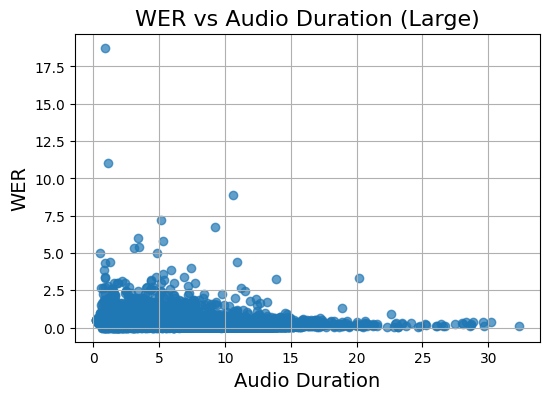

In [12]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_whisper_large["Duration"], 
    net_aigenerated_data_whisper_large["WER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("WER vs Audio Duration (Large)", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("WER", fontsize=14)
plt.grid(True)
plt.show()

In [25]:
from scipy.stats import spearmanr
rho, p = spearmanr(net_aigenerated_data_whisper_large.dropna()['Duration'], net_aigenerated_data_whisper_large.dropna()['WER'])
print(f"p-value = {p}")
print(f"rho = {rho}")

p-value = 0.0
rho = -0.40016065557461494


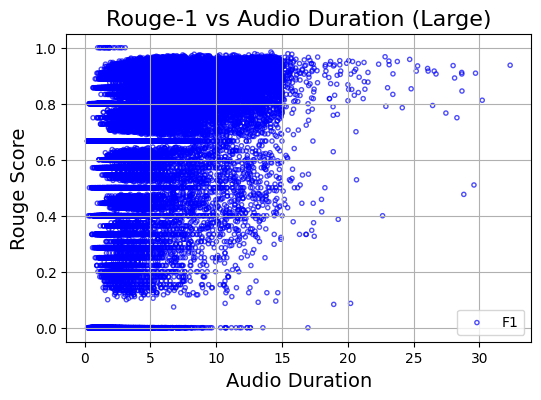

In [28]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_whisper_large["Duration"], 
#     net_aigenerated_data_whisper_large["stu-rouge1-precision"], 
#     facecolors="none", edgecolors='r',
#     label="Precision",
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_whisper_large["Duration"], 
#     net_aigenerated_data_whisper_large["stu-rouge1-recall"], 
#     facecolors="none", edgecolors='g',
#     label="Recall",
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_whisper_large["Duration"], 
    net_aigenerated_data_whisper_large["stu-rouge1-f1"], 
    facecolors="none", edgecolors='b',
    label="F1",
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-1 vs Audio Duration (Large)", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

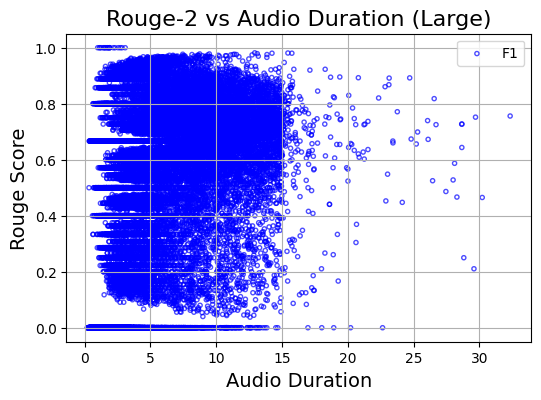

In [32]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_whisper_large["Duration"], 
#     net_aigenerated_data_whisper_large["stu-rouge2-precision"], 
#     facecolors="none", edgecolors='r',
#     label="Precision",
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_whisper_large["Duration"], 
#     net_aigenerated_data_whisper_large["stu-rouge2-recall"], 
#     facecolors="none", edgecolors='g',
#     label="Recall",
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_whisper_large["Duration"], 
    net_aigenerated_data_whisper_large["stu-rouge2-f1"], 
    facecolors="none", edgecolors='b',
    label="F1",
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-2 vs Audio Duration (Large)", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

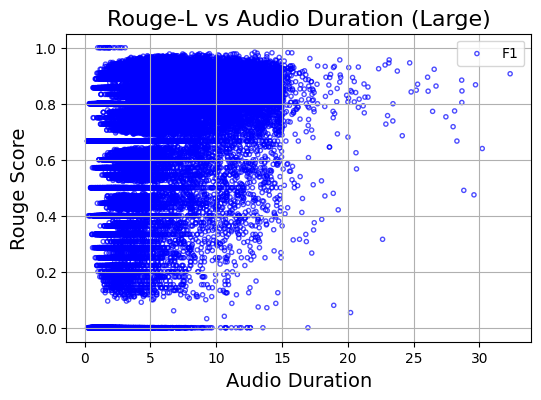

In [37]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_whisper_large["Duration"], 
#     net_aigenerated_data_whisper_large["stu-rougel-precision"], 
#     facecolors="none", edgecolors='r',
#     label="Precision",
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_whisper_large["Duration"], 
#     net_aigenerated_data_whisper_large["stu-rougel-recall"], 
#     facecolors="none", edgecolors='g',
#     label="Recall",
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_whisper_large["Duration"], 
    net_aigenerated_data_whisper_large["stu-rougel-f1"], 
    facecolors="none", edgecolors='b',
    label="F1",
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-L vs Audio Duration (Large)", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [39]:
from scipy.stats import spearmanr

rho, p = spearmanr(net_aigenerated_data_whisper_large.dropna()['Duration'], net_aigenerated_data_whisper_large.dropna()['stu-rouge1-f1'])
print(f"p-value [stuttering count & rouge-1 f1] = {p}")
print(f"rho [stuttering count & rouge-1 f1] = {rho}")


rho, p = spearmanr(net_aigenerated_data_whisper_large.dropna()['Duration'], net_aigenerated_data_whisper_large.dropna()['stu-rouge2-f1'])
print(f"p-value [stuttering count & rouge-2 f1] = {p}")
print(f"rho [stuttering count & rouge-2 f1] = {rho}")


rho, p = spearmanr(net_aigenerated_data_whisper_large.dropna()['Duration'], net_aigenerated_data_whisper_large.dropna()['stu-rougel-f1'])
print(f"p-value [stuttering count & rouge-L f1] = {p}")
print(f"rho [stuttering count & rouge-L f1] = {rho}")

p-value [stuttering count & rouge-1 f1] = 0.0
rho [stuttering count & rouge-1 f1] = 0.4644606385231864
p-value [stuttering count & rouge-2 f1] = 0.0
rho [stuttering count & rouge-2 f1] = 0.43077837823362336
p-value [stuttering count & rouge-L f1] = 0.0
rho [stuttering count & rouge-L f1] = 0.4194400336628004


***

# Imports & Ingestion of Data (Whisper Tiny) [skip if analyzed csv data exists]
**We will be using the data generated from `whisper-stu-eval.ipynb`.**

In [3]:
import pandas as pd
import numpy as np
import scipy 
import os
import sys
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
net_data = pd.DataFrame(columns=["Filename", "Start_time", "End_time", "Transcript"]) 

cols = list(pd.read_csv("net_aigenerated_data_whisper_tiny_performance_stu.csv", nrows=1))
print(cols)

net_aigenerated_data_whisper_tiny = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-whisper/net_aigenerated_data_whisper_tiny_performance_stu.csv', delimiter=',', usecols =[i for i in cols if "Unnamed:" not in i])

['Unnamed: 0', 'Filename', 'Start_time', 'End_time', 'Whisper_tiny', 'WER', 'Stuttering_Count', 'Stu-wer-compared-groundtruth', 'NA_Count', 'NA_Cleaned_Count', 'WER_Binned', 'stu-rouge1-precision', 'stu-rouge1-recall', 'stu-rouge1-f1', 'stu-rouge2-precision', 'stu-rouge2-recall', 'stu-rouge2-f1', 'stu-rougel-precision', 'stu-rougel-recall', 'stu-rougel-f1', 'Stu-rouge-compared-groundtruth', 'Duration', 'Freq_Duration', 'Freq_CharCount']


In [15]:
for folder in os.listdir(ds_transcript_path):
    if folder == "command_stats.xlsx" or folder == "command_stats.csv":
        continue
    for audio_sample in os.listdir(os.path.join(ds_transcript_path, f"{folder}")):
        if ("_A.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_A")])
        if ("_B.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_B")])
        if ("P" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"P{folder}")])

In [16]:
mask_pattern = r"\<.*?\>"
repetition_pattern = r"\[.*?\]"
annotation_pattern = r"/\w"


net_data = net_data.assign(Cleaned_Transcript=net_data['Transcript'].apply(lambda x: re.sub(annotation_pattern, "", re.sub(repetition_pattern, "", re.sub(mask_pattern, "", x)))))
net_data = net_data.assign(Stutterance_Count=net_data['Transcript'].apply(lambda x: len(re.findall(mask_pattern, x)) + len(re.findall(repetition_pattern, x)) + len(re.findall(annotation_pattern, x))))

In [17]:
net_data

,Filename,Start_time,End_time,Transcript,Cleaned_Transcript,Stutterance_Count
0,D0045_A,48.330,58.020,嗯，我[我/b我]现在已经工作了，我是/p一八年毕业的，然后我的专业是/p国际经济与贸易。,嗯，我现在已经工作了，我是一八年毕业的，然后我的专业是国际经济与贸易。,4
1,D0045_A,58.900,72.140,然后我现在嗯/i/p我现在的工作是/p[是]在/p[是在]<人民银行>，但是这个工作就是/p...,然后我现在嗯我现在的工作是在，但是这个工作就是可能快要就不干了。,8
2,D0045_A,74.100,81.260,嗯/i/p然后我平常的爱好是/p比较喜欢看电影，然后还喜欢打网球。,嗯然后我平常的爱好是比较喜欢看电影，然后还喜欢打网球。,3
3,D0045_A,84.930,86.320,嗯/i<overlap>结束了。,嗯结束了。,2
4,D0045_A,100.950,113.700,嗯，这个就是它[它]不是银行系统，然后它然/r后那个之所以不干，是因为就是这个，嗯/i就是现...,嗯，这个就是它不是银行系统，然后它然后那个之所以不干，是因为就是这个，嗯就是现在人民银行的县...,4
...,...,...,...,...,...,...
135,P0030,3202.732,3213.472,单曲循环歌曲最[最最]爱的为何没结果。,单曲循环歌曲最爱的为何没结果。,1
136,P0030,3216.222,3221.042,来[来]一首朴/p树的歌。,来一首朴树的歌。,2
137,P0030,3225.732,3236.142,搜[搜/r/b搜]索小灿的多/p年/p/r/b以后。,搜索小灿的多年以后。,7
138,P0030,3240.652,3253.172,播放半吨/b/r/p孙弟歌孙兄弟的歌。,播放半吨孙弟歌孙兄弟的歌。,3


In [18]:
### NOT NEEDED BECAUSE THE DATA CSV ALREADY HAS THE CLEANED_TRANSCRIPT AFTER FIRST PROCESSING
### [ ] ONLY UNCOMMENT IF IT IS FIRST RUN ON THE RAW DATA

## Assign back the cleaned transcript and original transcript
# merged_data = net_aigenerated_data_whisper_tiny.merge(
#     net_data[['Filename', 'Start_time', 'Cleaned_Transcript', 'Transcript']],
#     on=['Filename', 'Start_time'],
#     how='left'
# )

# net_aigenerated_data_whisper_tiny['Cleaned_Transcript'] = merged_data['Cleaned_Transcript']
# net_aigenerated_data_whisper_tiny['GroundTruth_Transcript'] = merged_data['Transcript']

In [5]:
net_aigenerated_data_whisper_tiny.describe()

,Start_time,End_time,WER,Stuttering_Count,NA_Count,NA_Cleaned_Count,WER_Binned,stu-rouge1-precision,stu-rouge1-recall,stu-rouge1-f1,stu-rouge2-precision,stu-rouge2-recall,stu-rouge2-f1,stu-rougel-precision,stu-rougel-recall,stu-rougel-f1,Duration,Freq_Duration,Freq_CharCount
count,37253.000000,37253.000000,36916.000000,36916.000000,37253.0,37253.0,36916.000000,36916.000000,36916.000000,36916.000000,36916.000000,36916.000000,36916.000000,36916.000000,36916.000000,36916.000000,37253.000000,36916.000000,36916.000000
mean,1973.473702,1978.229497,0.662262,1.102638,332.0,0.0,0.662355,0.364666,0.305999,0.329649,0.197677,0.162003,0.176467,0.360276,0.297784,0.322564,4.755795,0.166835,0.064293
std,1026.628912,1024.827293,0.985791,1.783137,0.0,0.0,0.985816,0.330909,0.274995,0.295897,0.273626,0.221831,0.241419,0.328792,0.268646,0.290872,3.755041,0.255867,0.127759
min,0.490000,0.840000,0.000000,0.000000,332.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.220000,0.000000,0.000000
25%,1122.560000,1130.110000,0.363636,0.000000,332.0,0.0,0.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.910000,0.000000,0.000000
50%,2105.533000,2108.501000,0.545455,0.000000,332.0,0.0,0.550000,0.333333,0.285714,0.307692,0.000000,0.000000,0.000000,0.333333,0.272727,0.285714,3.340000,0.000000,0.000000
75%,2768.832000,2772.105000,0.750000,2.000000,332.0,0.0,0.750000,0.650000,0.529412,0.588235,0.375000,0.312500,0.333333,0.636364,0.500000,0.571429,6.800000,0.287356,0.086957
max,4157.869000,4168.639000,73.333333,17.000000,332.0,0.0,73.330000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,32.330000,3.773585,1.750000


**Now we have raw data of all audio transcriptions from datasets [updated_annotation_deid_full] in ```net_data``` and AI predicted transcriptions in ```net_aigenerated_data_whisper_large```**

In [45]:
## SAVING

# net_aigenerated_data_whisper_tiny.to_csv('net_aigenerated_data_whisper_tiny_performance_stu.csv', sep=',')

***

## Load Data file if prior analysis was done

In [20]:
net_aigenerated_data_whisper_tiny = pd.read_csv(f"{os.getcwd()}/net_aigenerated_data_whisper_tiny_performance_stu.csv", index_col=0)
net_aigenerated_data_whisper_tiny

,Filename,Start_time,End_time,Whisper_tiny,WER,Stuttering_Count,Stu-wer-compared-groundtruth,NA_Count,NA_Cleaned_Count,WER_Binned,...,stu-rouge1-recall,stu-rouge1-f1,stu-rouge2-precision,stu-rouge2-recall,stu-rouge2-f1,stu-rougel-precision,stu-rougel-recall,stu-rougel-f1,Stu-rouge-compared-groundtruth,Duration
0,D0001_A,2081.540000,2109.650000,我说出来就比较不需要时间然后那个食别的他的就是他等你一会那个话还没有收完都还没有说出来的话他...,0.278351,1.0,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...,332,0,0.28,...,0.710526,0.729730,0.480769,0.409836,0.442478,0.724138,0.600000,0.656250,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...,28.110000
1,D0001_A,790.130000,796.580000,在牙我收到,0.800000,1.0,电视剧有，我说的话。,332,0,0.80,...,0.142857,0.181818,0.000000,0.000000,0.000000,0.250000,0.142857,0.181818,电视剧有，我说的话。,6.450000
2,D0001_A,1562.083518,1586.220000,在不计是不怎么平分是不怎么好的就因为平分缺的那些人都在说然后我做好产的那个就那么请问但是就一...,0.437500,10.0,这部剧是不怎么，评分是不怎么好的，呃就因为呃评论区的那些人，他们都在说，呃男二号就好惨的那个...,332,0,0.44,...,0.516129,0.551724,0.333333,0.275000,0.301370,0.571429,0.476190,0.519481,这部剧是不怎么，评分是不怎么好的，呃就因为呃评论区的那些人，他们都在说，呃男二号就好惨的那个...,24.136482
3,D0001_A,2016.780000,2035.673559,很精准的兴非女人还是兴非出手来的就我记得她是叫兴非我之前就是她,0.500000,7.0,很精准，对，呃讯飞语音还是讯飞助手来着，就我记得它是叫讯飞，我之前就是它呃是,332,0,0.50,...,0.550000,0.611111,0.300000,0.214286,0.250000,0.571429,0.387097,0.461538,很精准，对，呃讯飞语音还是讯飞助手来着，就我记得它是叫讯飞，我之前就是它呃是,18.893559
4,D0001_A,1682.670000,1709.110000,一个那个是叫抓来的我忘了就是出现了你那个一个人然后他就这了一把剑然后就就把那个拿到给葬撒了就...,0.367647,8.0,一个那个是嗯叫啥来着，我忘了，就是出现了另一个人，然后呢他就射了一把剑，然后就把那个嗯男二号...,332,0,0.37,...,0.606061,0.666667,0.378378,0.318182,0.345679,0.717949,0.571429,0.636364,一个那个是嗯叫啥来着，我忘了，就是出现了另一个人，然后呢他就射了一把剑，然后就把那个嗯男二号...,26.440000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,"單許宣傳歌曲,這樣而已",0.727273,0.0,单曲循环歌曲这样而已。,332,0,0.73,...,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,单曲循环歌曲这样而已。,2.730000
37249,P0070,2782.496000,2783.706000,楊秘的電影,0.666667,0.0,杨幂的电影。,332,0,0.67,...,0.250000,0.285714,0.000000,0.000000,0.000000,0.333333,0.250000,0.285714,杨幂的电影。,1.210000
37250,P0070,2995.296000,2998.116000,"你好米哈,今天菜油駕怎么样",0.400000,0.0,你好，米雅，今天柴油价怎么样。,332,0,0.40,...,0.375000,0.400000,0.000000,0.000000,0.000000,0.428571,0.333333,0.375000,你好，米雅，今天柴油价怎么样。,2.820000
37251,P0070,2604.066000,2606.656000,單取新環科曲劉旅光這個,0.750000,0.0,单曲循环歌曲琉璃光之歌。,332,0,0.75,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,单曲循环歌曲琉璃光之歌。,2.590000


***

## Compute Audio Length

In [21]:
net_aigenerated_data_whisper_tiny = net_aigenerated_data_whisper_tiny.assign(Duration=net_aigenerated_data_whisper_tiny['End_time']-net_aigenerated_data_whisper_tiny['Start_time'])

In [22]:
## SAVE THE DURATION CALCULATION
net_aigenerated_data_whisper_tiny.to_csv('net_aigenerated_data_whisper_tiny_performance_stu.csv', sep=',')

***

## Visualization of Scores

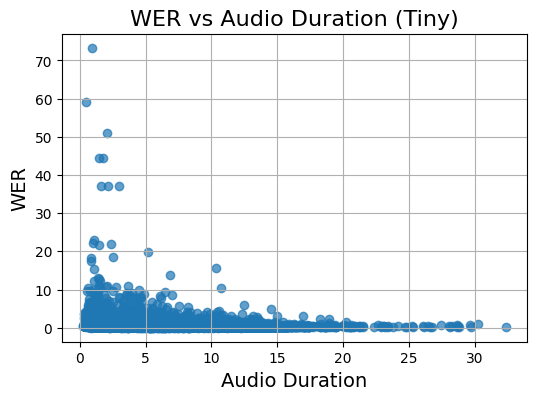

In [23]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_whisper_tiny["Duration"], 
    net_aigenerated_data_whisper_tiny["WER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("WER vs Audio Duration (Tiny)", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("WER", fontsize=14)
plt.grid(True)
plt.show()

In [40]:
from scipy.stats import spearmanr
rho, p = spearmanr(net_aigenerated_data_whisper_tiny.dropna()['Duration'], net_aigenerated_data_whisper_tiny.dropna()['WER'])
print(f"p-value = {p}")
print(f"rho = {rho}")

p-value = 0.0
rho = -0.4148935696699132


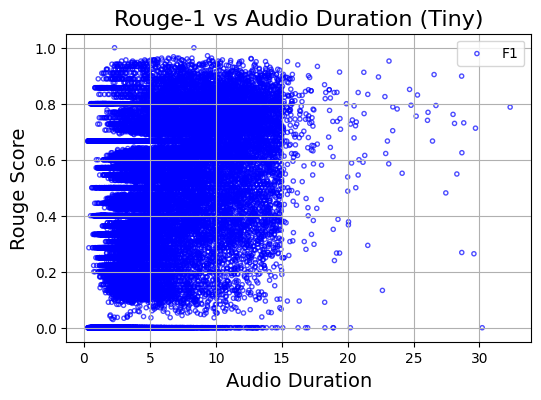

In [43]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_whisper_tiny["Duration"], 
#     net_aigenerated_data_whisper_tiny["stu-rouge1-precision"], 
#     facecolors="none", edgecolors='r',
#     label="Precision",
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_whisper_tiny["Duration"], 
#     net_aigenerated_data_whisper_tiny["stu-rouge1-recall"], 
#     facecolors="none", edgecolors='g',
#     label="Recall",
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_whisper_tiny["Duration"], 
    net_aigenerated_data_whisper_tiny["stu-rouge1-f1"], 
    facecolors="none", edgecolors='b',
    label="F1",
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-1 vs Audio Duration (Tiny)", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

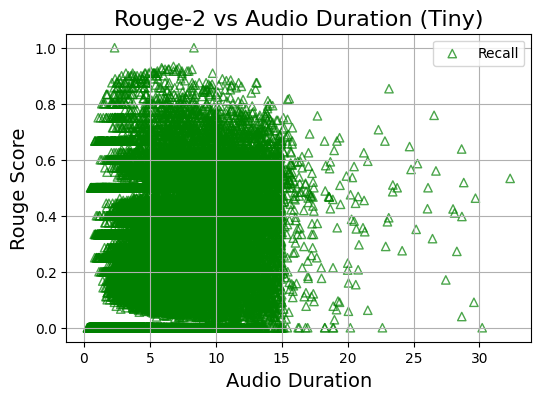

In [46]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_whisper_tiny["Duration"], 
#     net_aigenerated_data_whisper_tiny["stu-rouge2-precision"], 
#     facecolors="none", edgecolors='r',
#     label="Precision",
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_whisper_tiny["Duration"], 
    net_aigenerated_data_whisper_tiny["stu-rouge2-recall"], 
    facecolors="none", edgecolors='g',
    label="Recall",
    marker="^",
    alpha=0.7  # Handle overlapping points
)

# plt.scatter(
#     net_aigenerated_data_whisper_tiny["Duration"], 
#     net_aigenerated_data_whisper_tiny["stu-rouge2-f1"], 
#     facecolors="none", edgecolors='b',
#     label="F1",
#     marker=".",
#     alpha=0.7  # Handle overlapping points
# )

plt.title("Rouge-2 vs Audio Duration (Tiny)", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

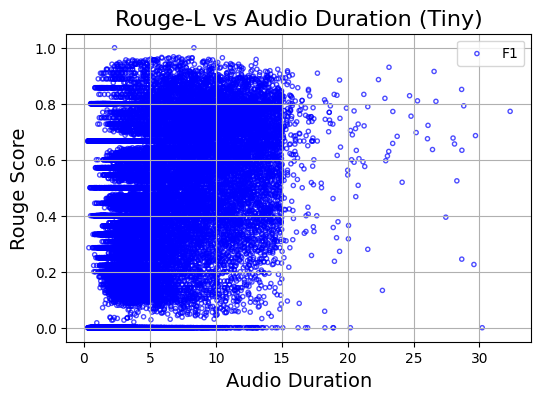

In [49]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_whisper_tiny["Duration"], 
#     net_aigenerated_data_whisper_tiny["stu-rougel-precision"], 
#     facecolors="none", edgecolors='r',
#     label="Precision",
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_whisper_tiny["Duration"], 
#     net_aigenerated_data_whisper_tiny["stu-rougel-recall"], 
#     facecolors="none", edgecolors='g',
#     label="Recall",
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_whisper_tiny["Duration"], 
    net_aigenerated_data_whisper_tiny["stu-rougel-f1"], 
    facecolors="none", edgecolors='b',
    label="F1",
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-L vs Audio Duration (Tiny)", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [51]:
from scipy.stats import spearmanr

rho, p = spearmanr(net_aigenerated_data_whisper_tiny.dropna()['Duration'], net_aigenerated_data_whisper_tiny.dropna()['stu-rouge1-f1'])
print(f"p-value [stuttering count & rouge-1 f1] = {p}")
print(f"rho [stuttering count & rouge-1 f1] = {rho}")


rho, p = spearmanr(net_aigenerated_data_whisper_tiny.dropna()['Duration'], net_aigenerated_data_whisper_tiny.dropna()['stu-rouge2-f1'])
print(f"p-value [stuttering count & rouge-2 f1] = {p}")
print(f"rho [stuttering count & rouge-2 f1] = {rho}")


rho, p = spearmanr(net_aigenerated_data_whisper_tiny.dropna()['Duration'], net_aigenerated_data_whisper_tiny.dropna()['stu-rougel-f1'])
print(f"p-value [stuttering count & rouge-L f1] = {p}")
print(f"rho [stuttering count & rouge-L f1] = {rho}")

p-value [stuttering count & rouge-1 f1] = 0.0
rho [stuttering count & rouge-1 f1] = 0.5715230961429668
p-value [stuttering count & rouge-2 f1] = 0.0
rho [stuttering count & rouge-2 f1] = 0.6080838055965158
p-value [stuttering count & rouge-L f1] = 0.0
rho [stuttering count & rouge-L f1] = 0.5655644492232648
